In [1]:
# import libraries
import datetime as dt
import pandas as pd
import scipy
import statsmodels.api as sm
from pmdarima.arima import auto_arima

# never print matching warnings
import warnings
warnings.filterwarnings('ignore')

#for data visualization
import plotly.offline as pyoff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
# initiate the Plotly Notebook mode to use plotly offline
init_notebook_mode(connected=True)

In [3]:
# load sales data to dataframe
data = pd.read_csv('OnlineRetail.csv',header=0, encoding = 'unicode_escape')
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50,4.95,12680.0,France


In [4]:
# seeing full summary of the retail data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# there are null data in description and the CustomerID columns
# check and clean null data
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# clean null data and get data statistics summarize 
dropna = data.dropna(subset=['CustomerID'])
dropna.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# check duplicates data
dropna.duplicated().sum()

5225

In [8]:
# clean duplicated data and get data statistics summarize 
dropdup = dropna.drop_duplicates()
dropdup.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# the min for unit price = 0 and the min for Quantity is a negative value
# clean up negative values most likely from refunds
retail_data=dropdup[(dropdup['Quantity'] > 0) & (dropdup['UnitPrice'] > 0)]
retail_data.describe() 

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [10]:
# checking data set size
retail_data.shape

(392692, 8)

In [11]:
# convert InvoiceDate to datetime
retail_data['InvoiceMonth'] = pd.DatetimeIndex(retail_data.InvoiceDate).date
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01


In [12]:
# restricting data to the United Kingdom only since it has the most customers
uk_data = retail_data.loc[retail_data['Country'] == 'United Kingdom']
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01


In [13]:
# calculate monthly revenue and create a new dataframe with InvoiceMonth and Revenue columns
uk_data['Revenue'] = uk_data['UnitPrice'] * uk_data['Quantity']
uk_revenue = uk_data.groupby(['InvoiceMonth'])['Revenue'].sum().round().reset_index()
uk_revenue.set_index('InvoiceMonth', inplace=True)
uk_revenue.sample(10)

,Revenue
InvoiceMonth,
2011-12-08,47024.0
2011-05-18,29644.0
2011-07-27,16541.0
2011-08-22,26603.0
2011-10-13,22804.0
2011-10-25,32946.0
2011-12-02,40520.0
2010-12-08,35059.0
2011-01-19,9093.0


In [14]:
uk_revenue.shape

(305, 1)

In [14]:
# graph uk_revenue
uk_revenue.index = pd.to_datetime(uk_revenue.index)
uk_revenue.columns = ['Revenue']
uk_revenue.iplot(title="UK Revenue from December 2010 to December 2011")

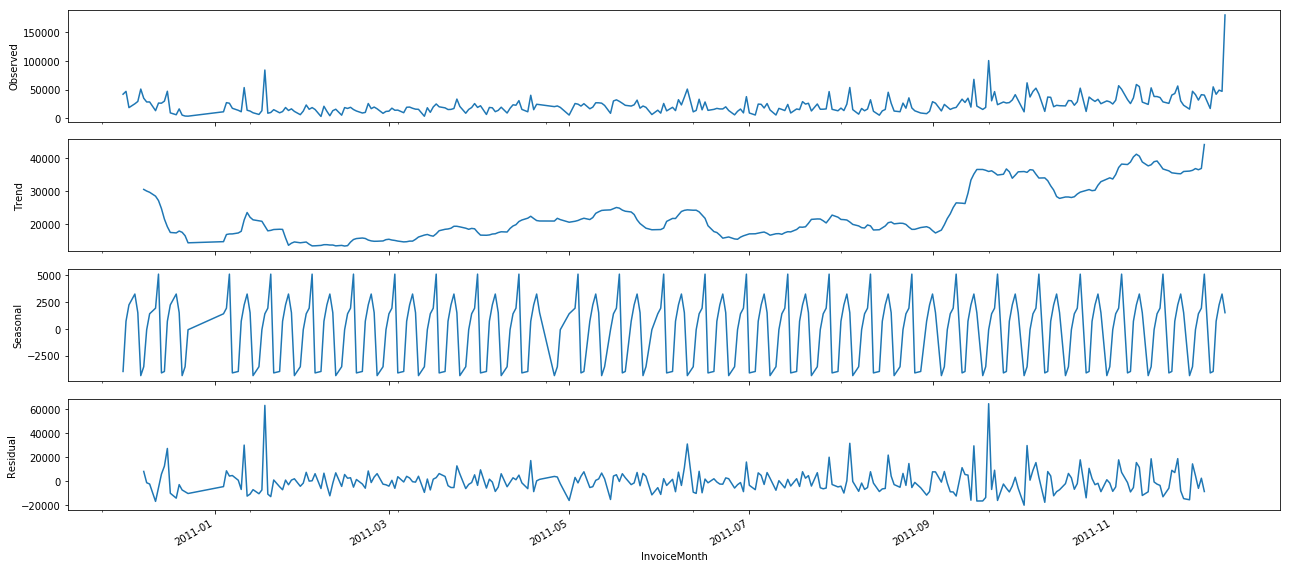

In [18]:
# decompose our time series into three distinct components: trend, seasonality, and noise
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(uk_revenue, model='additive', freq=12 )
fig = decomposition.plot()
plt.show()

In [56]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    plt.figure(figsize=(18, 8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Revenue'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

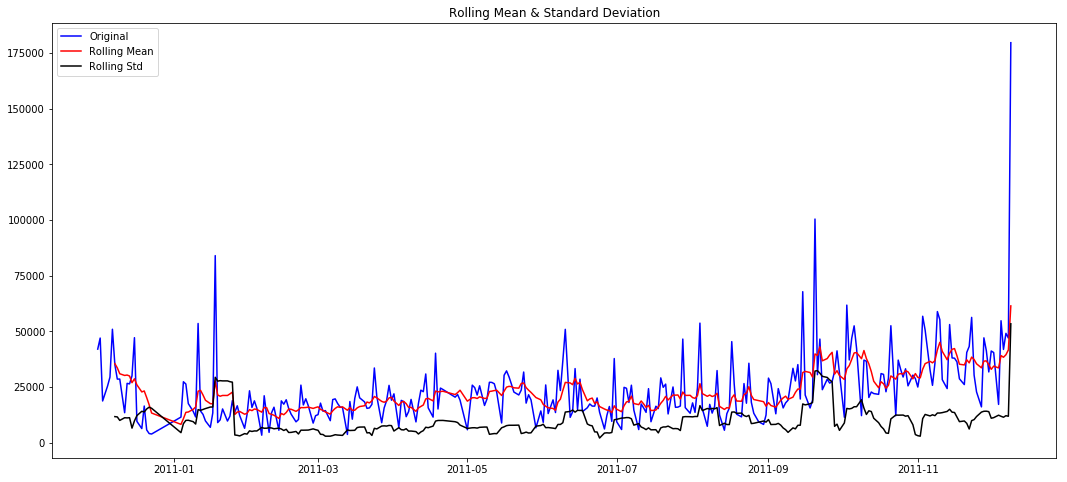

Results of Dickey-Fuller Test:
Test Statistic                  -0.722821
p-value                          0.840750
#Lags Used                       5.000000
Number of Observations Used    299.000000
Critical Value (1%)             -3.452411
Critical Value (5%)             -2.871255
Critical Value (10%)            -2.571947
dtype: float64


In [57]:
test_stationarity(uk_revenue)

In [ ]:
# Augmented Dickey-Fuller test (ADF)
# ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.
# Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
# Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
# p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
# p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

In [19]:
# ARIMA, which stands for Autoregressive Integrated Moving Average
# grid search
stepwise_model = auto_arima(uk_revenue, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=6502.591, BIC=6520.975, Fit time=1.124 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6676.015, BIC=6683.368, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=6561.870, BIC=6576.577, Fit time=0.508 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=6473.452, BIC=6488.159, Fit time=2.366 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=6504.356, BIC=6522.740, Fit time=0.967 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=6562.934, BIC=6573.964, Fit time=0.163 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=6507.167, BIC=6525.550, Fit time=3.813 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=6475.949, BIC=6498.010, Fit time=13.353 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=6587.761, BIC=6598.791, Fit time=0.511 seconds
Fit ARIMA: order=(0, 1, 2) 

In [20]:
# plugging the optimal parameter values into a new SARIMAX model
# analyze this particular model
mod = sm.tsa.statespace.SARIMAX(uk_revenue,
                                order=(1, 1, 2),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8891      0.162     -5.484      0.000      -1.207      -0.571
ma.L1         -0.0365      0.236     -0.155      0.877      -0.499       0.426
ma.L2         -0.7096      0.184     -3.847      0.000      -1.071      -0.348
ma.S.L12      -0.7902      0.051    -15.525      0.000      -0.890      -0.690
sigma2      3.135e+08    1.3e-09   2.41e+17      0.000    3.13e+08    3.13e+08


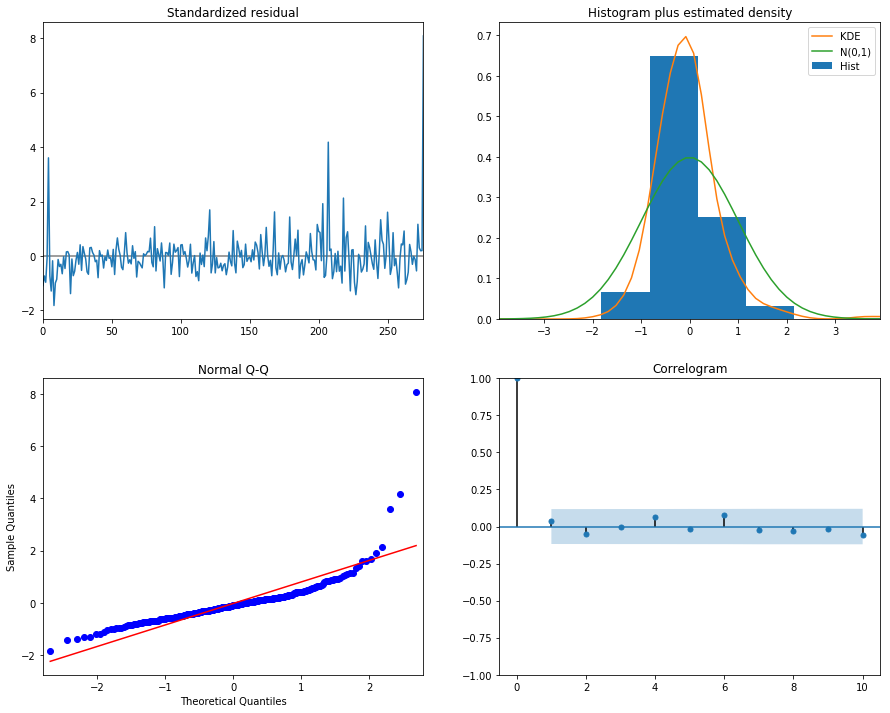

In [37]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()